![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2F03+-+BigQuery+ML+%28BQML%29&file=03f+-+BQML+Logistic+Regression+With+Hyperparameter+Tuning.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20%28BQML%29/03f%20-%20BQML%20Logistic%20Regression%20With%20Hyperparameter%20Tuning.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2F03%2520-%2520BigQuery%2520ML%2520%2528BQML%2529%2F03f%2520-%2520BQML%2520Logistic%2520Regression%2520With%2520Hyperparameter%2520Tuning.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20%28BQML%29/03f%20-%20BQML%20Logistic%20Regression%20With%20Hyperparameter%20Tuning.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/03%20-%20BigQuery%20ML%20%28BQML%29/03f%20-%20BQML%20Logistic%20Regression%20With%20Hyperparameter%20Tuning.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# 03f - Logistic Regression With Hyperparameter Tuning

In this notebook, BigQuery ML (BQML) is used to create a logistic regression model while using hyperparameter tuning for `L1` and `L2` regularization.

**Logistic Regression**

Logistic Regression is a statistical model for the probability, `p`, of a class.  This is accomplished by fitting a linear combination of the features to the log-odds of the class.  The log-odds is called the logit and is the logarithm ($ln$) of the odds ($\frac{p}{1-p}$).  This is a supervised learning approach where the labels, classes, are learned as function of the features.  While the model is estimating the probability of a class `p` which might be considered regression, the probabilities are used to assign a class which is classification.

Reference:
- [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning)

**BigQuery ML (BQML)**

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Hyperparameter Tuning**

When training a machine learning model it is helpful to find the optimal values for hyperparameters, parameters set before training begins.  These are not learned parameters like the coefficents of a model.  Rather than manually iterating these parameters we want to sequently test and focus in on optimal values.  The focusing part of the iterations is done in BQML by utilizing the [Vertex AI Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview) service by default.

Each `MODEL_TYPE` in BQML has parameters than can be tuned as [listed here](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#hyperparameters_and_objectives).  

**Prerequisites:**
- [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

**Resources:**
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [BigQuery](https://cloud.google.com/bigquery)
    - [Documentation:](https://cloud.google.com/bigquery/docs/query-overview)
    - [API:](https://cloud.google.com/bigquery/docs/reference/libraries-overview)
        - [Clients](https://cloud.google.com/bigquery/docs/reference/libraries)
            - [Python SDK:](https://github.com/googleapis/python-bigquery)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/bigquery/latest)
- [Vertex AI](https://cloud.google.com/vertex-ai)
    - [Documentation:](https://cloud.google.com/vertex-ai/docs/start/introduction-unified-platform)
    - [API:](https://cloud.google.com/vertex-ai/docs/reference)
        - [Clients:](https://cloud.google.com/vertex-ai/docs/start/client-libraries)
            - [Python SDK:](https://github.com/googleapis/python-aiplatform)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/aiplatform/latest)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/03f_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/03f_console.png" width="45%">
</p>

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20(BQML)/03f%20-%20BQML%20Logistic%20Regression%20With%20Hyperparameter%20Tuning.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    
    #installs
    # Vertex AI GenAI Studio SDK - Update the aiplatform SDK
    !pip install google.cloud.aiplatform -U -q --user
    !pip install --upgrade gcsfs -U -q --user
    !pip install --upgrade google-cloud-bigquery -U -q --user
    !pip install --upgrade google-cloud-bigquery-storage -U -q --user
    
    # Enable Vertex AI For This Project
    !gcloud services enable aiplatform.googleapis.com

    # restart runtime
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)    
except Exception:
    pass

---
## Setup

inputs:

In [12]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [13]:
REGION = 'us-central1'
EXPERIMENT = 'logistic-regression-hpt'
SERIES = 'bqml'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Resources for serving BigQuery Model Exports
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [14]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

from google.api import httpbody_pb2
import json

clients:

In [15]:
bq = bigquery.Client(project = PROJECT_ID)
aiplatform.init(project = PROJECT_ID, location = REGION)

parameters:

In [16]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{SERIES}_{EXPERIMENT}_{TIMESTAMP}'

environment:

In [17]:
DIR = f"temp/{EXPERIMENT}"

!rm -rf {DIR}
!mkdir -p {DIR}

---
## Review Data

The data source here was prepared in [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb).  In this notebook we will use prepared BigQuery table to build a model with BigQuery ML (BQML).

This is a table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction

The data preparation included added splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`).  Additionally, a unique identifier was added to each transaction, `transaction_id`.  

Review the number of records for each level of Class (VAR_TARGET) for each of the data splits:

In [18]:
query = f"""
SELECT splits, {VAR_TARGET}, count(*) as n
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, {VAR_TARGET}
"""
bq.query(query = query).to_dataframe()

,splits,Class,n
0,TEST,0,28455
1,TEST,1,47
2,TRAIN,0,227664
3,TRAIN,1,397
4,VALIDATE,0,28196
5,VALIDATE,1,48


Further review the balance of the target variable (VAR_TARGET) for each split as a percentage of the split:

In [19]:
query = f"""
WITH
    COUNTS as (SELECT splits, {VAR_TARGET}, count(*) as n FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` GROUP BY splits, {VAR_TARGET})
    
SELECT *,
    SUM(n) OVER() as total,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY {VAR_TARGET})) as n_pct_class,
    SAFE_DIVIDE(n, SUM(n) OVER(PARTITION BY splits)) as n_pct_split,
    SAFE_DIVIDE(SUM(n) OVER(PARTITION BY {VAR_TARGET}), SUM(n) OVER()) as class_pct_total
FROM COUNTS
"""
review = bq.query(query = query).to_dataframe()
review

,splits,Class,n,total,n_pct_class,n_pct_split,class_pct_total
0,VALIDATE,0,28196,284807,0.099172,0.998301,0.998273
1,VALIDATE,1,48,284807,0.097561,0.001699,0.001727
2,TEST,0,28455,284807,0.100083,0.998351,0.998273
3,TEST,1,47,284807,0.095528,0.001649,0.001727
4,TRAIN,0,227664,284807,0.800746,0.998259,0.998273
5,TRAIN,1,397,284807,0.806911,0.001741,0.001727


---
## This Run

In [20]:
print(f'This run will create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'This run will create Vertex AI model: {BQ_PROJECT}.{BQ_DATASET}.bqml_{SERIES}_{EXPERIMENT}')
print(f'The runs timestamp Is: {TIMESTAMP}')

This run will create BQML model: statmike-mlops-349915.fraud.bqml_logistic-regression-hpt_20230627123029
This run will create Vertex AI model: statmike-mlops-349915.fraud.bqml_bqml_logistic-regression-hpt
The runs timestamp Is: 20230627123029


---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign `TRAIN`, `EVAL`, and `TEST` data splits.
    - the `CASE` statement maps the validation data to `EVAL` as expected by hyperparameter tuning (rather than `VALIDATE`)
    - note that this is different behavior for `data_split_col` with hyperparameter tuning than without hyperparameter tuning
    - hyperparameter suggestions are based on the metric calculated with the evaluation data at each intermediate step
    
This example includes the [training options](https://cloud.google.com/bigquery-ml/docs/create_vertex) to register the resulting model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).

**Hyperparameter Tuning**

The [following options](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#create_model_syntax) are added to the model training code for BQML to guide the hyperparameter tuning of `L1` and `L2` regularization:

```SQL
l1_reg = HPARAM_RANGE(0, 1000),
l2_reg = HPARAM_RANGE(0, 1000),
hparam_tuning_algorithm = 'VIZIER_DEFAULT',
hparam_tuning_objectives = ['ROC_AUC'],
num_trials = 20,
max_parallel_trials = 2
```

This instructs BQML to use the Vertex AI Vizier service to find values of `l1_reg` and `l2_reg` that optimize 'roc_auc' by doing 4 trials at a time until 20 trials have been completed.


In [21]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        l1_reg = HPARAM_RANGE(0, 1000),
        l2_reg = HPARAM_RANGE(0, 1000),
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['ROC_AUC'],
        num_trials = 20,
        max_parallel_trials = 2,
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{SERIES}_{EXPERIMENT}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}']
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'VALIDATE' THEN 'EVAL'
        ELSE splits
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
print(query)


CREATE OR REPLACE MODEL `statmike-mlops-349915.fraud.bqml_logistic-regression-hpt_20230627123029`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['Class'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        l1_reg = HPARAM_RANGE(0, 1000),
        l2_reg = HPARAM_RANGE(0, 1000),
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['ROC_AUC'],
        num_trials = 20,
        max_parallel_trials = 2,
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_bqml_logistic-regression-hpt',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['run-20230627123029']
    ) AS
SELECT * EXCEPT(transaction_id, splits),
    CASE
        WHEN splits = 'VALIDATE' THEN 'EVAL'
        ELSE splits
    END AS custom_splits
FROM `statmike-mlops-349915.fraud.fraud_prepped`



In [22]:
job = bq.query(query = query)
job.result()

In [23]:
(job.ended-job.started).total_seconds()

883.242

In [24]:
job.total_bytes_processed

1453640300

Add labels to the model in BigQuery:

In [25]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [26]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [27]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfraud!3sbqml_logistic-regression-hpt_20230627123029


### Check out this model in the Vertex AI Model Registry

In [29]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL}?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_bqml_logistic-regression-hpt_20230627123029?project=statmike-mlops-349915


### Feature and Training Review

Review the Model Inputs, the feature information, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [30]:
feature_info = bq.query(
    query = f"""
        SELECT *
        FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
feature_info

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,Time,0.000000,172792.000000,94811.116749,85332.000000,47493.531641,<NA>,0,<NA>
1,V1,-56.407510,2.454930,-0.000215,0.027382,1.958173,<NA>,0,<NA>
2,V2,-72.715728,22.057729,0.000316,0.058447,1.649662,<NA>,0,<NA>
3,V3,-48.325589,9.382558,-0.000525,0.183854,1.520173,<NA>,0,<NA>
4,V4,-5.600607,16.875344,0.000695,-0.035812,1.415309,<NA>,0,<NA>
5,V5,-113.743307,34.801666,-0.001264,-0.052977,1.381807,<NA>,0,<NA>
6,V6,-26.160506,73.301626,0.002089,-0.264349,1.334135,<NA>,0,<NA>
7,V7,-43.557242,120.589494,-0.000721,0.034484,1.245465,<NA>,0,<NA>
8,V8,-73.216718,19.168327,-0.001064,0.027078,1.205023,<NA>,0,<NA>
9,V9,-13.434066,15.594995,0.001406,-0.054755,1.100121,<NA>,0,<NA>


Retrieve the trial info for the hyperparameter tuning trials with [ML.TRIAL_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-trial-info):

In [33]:
trials = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRIAL_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
trials

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'l1_reg': 1e-14, 'l2_reg': 1e-14}",{'roc_auc': 0.9537232767232767},0.117352,0.117913,SUCCEEDED,None,False
1,2,"{'l1_reg': 5.4904207538718e-11, 'l2_reg': 5.47...",{'roc_auc': 0.9537232767232767},0.117352,0.117913,SUCCEEDED,None,False
2,3,"{'l1_reg': 6.599407074203018e-07, 'l2_reg': 1e...",{'roc_auc': 0.9537232767232767},0.117352,0.117913,SUCCEEDED,None,False
3,4,"{'l1_reg': 1.4404391944595593e-06, 'l2_reg': 1...",{'roc_auc': 0.9537232767232767},0.117352,0.117913,SUCCEEDED,None,False
4,5,"{'l1_reg': 2.911290879124974e-11, 'l2_reg': 0....",{'roc_auc': 0.9537442557442557},0.117281,0.117840,SUCCEEDED,None,False
5,6,"{'l1_reg': 0.18076296569918437, 'l2_reg': 0.18...",{'roc_auc': 0.9537652347652348},0.117185,0.117742,SUCCEEDED,None,False
6,7,"{'l1_reg': 1000.0, 'l2_reg': 758.4744813307261}",{'roc_auc': 0.9634755244755244},0.669955,0.667117,SUCCEEDED,None,False
7,8,"{'l1_reg': 2.311859291956475e-06, 'l2_reg': 10...",{'roc_auc': 0.9659300699300699},0.667190,0.663684,SUCCEEDED,None,True
8,9,"{'l1_reg': 1e-14, 'l2_reg': 1000.0}",{'roc_auc': 0.9659300699300699},0.667190,0.663684,SUCCEEDED,None,True
9,10,"{'l1_reg': 6.044595977681315e-10, 'l2_reg': 10...",{'roc_auc': 0.9659300699300699},0.667190,0.663684,SUCCEEDED,None,True


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [34]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,VALIDATE,8,0.006135,0.958333,0.736086,0.012192,0.788194,0.965930
1,TEST,8,0.006008,0.978723,0.732931,0.011942,0.733832,0.977393
2,TRAIN,8,0.006415,0.989924,0.733098,0.012748,0.747044,0.986035


### Confusion Matrix

Review the confusion matrix for each split with [ML.CONFUSION_MATRIX](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [35]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,8,0,166798,60866
1,8,1,4,393


In [36]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,8,0,20744,7452
1,8,1,2,46


In [37]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,8,0,20844,7611
1,8,1,1,46


### ROC Curve

Retrieve the ROC Curve for each split using [ML.ROC_CURVE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [38]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
ORDER BY false_positive_rate
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,8,1.000000,0.702771,0.000198,279,45,227619,118
1,8,0.827149,0.866499,0.008657,344,1971,225693,53
2,8,0.749170,0.894207,0.018488,355,4209,223455,42
3,8,0.682884,0.916877,0.028564,364,6503,221161,33
4,8,0.657446,0.929471,0.038306,369,8721,218943,28


In [39]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
ORDER BY false_positive_rate
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,8,1.000000,0.708333,0.000284,34,8,28188,14
1,8,0.822554,0.875000,0.008654,42,244,27952,6
2,8,0.754818,0.875000,0.018584,42,524,27672,6
3,8,0.687979,0.916667,0.028515,44,804,27392,4
4,8,0.658329,0.916667,0.038481,44,1085,27111,4


In [40]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
ORDER BY false_positive_rate
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,8,1.000000,0.702128,0.000176,33,5,28450,14
1,8,0.824563,0.872340,0.008575,41,244,28211,6
2,8,0.745803,0.872340,0.018626,41,530,27925,6
3,8,0.684179,0.893617,0.028607,42,814,27641,5
4,8,0.657189,0.914894,0.038658,43,1100,27355,4


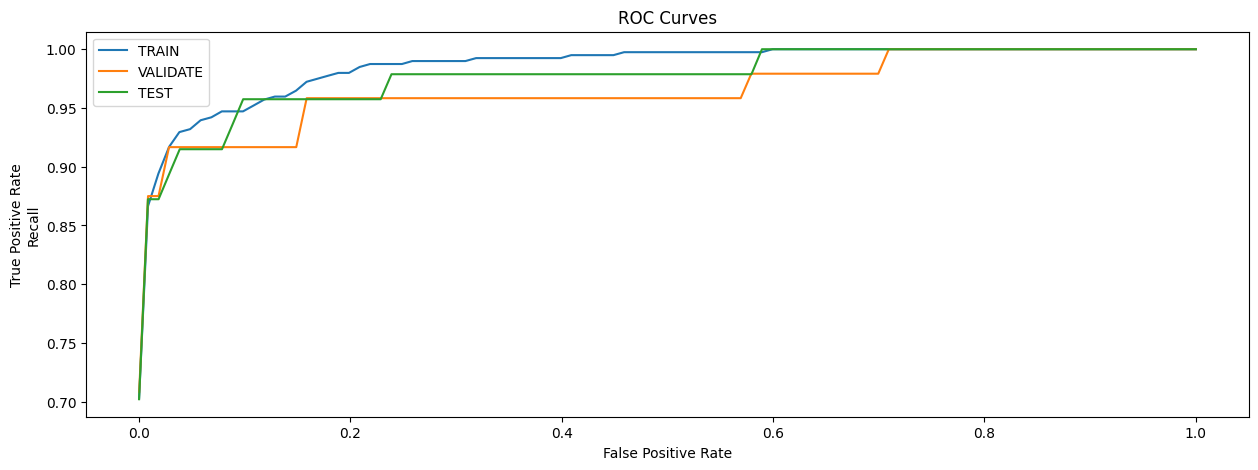

In [41]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [42]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [43]:
pred.columns

Index(['trial_id', 'predicted_Class', 'predicted_Class_probs', 'Time', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class',
       'transaction_id', 'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [44]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,1,"[{'label': 1, 'prob': 0.5323487401693949}, {'l...",TEST
1,0,0,"[{'label': 1, 'prob': 0.450688224229312}, {'la...",TEST
2,0,1,"[{'label': 1, 'prob': 0.5422210152055954}, {'l...",TEST
3,0,0,"[{'label': 1, 'prob': 0.4221969289239093}, {'l...",TEST
4,0,0,"[{'label': 1, 'prob': 0.4227873748860122}, {'l...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prob`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [45]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.46765125983060507},
  {'label': 1, 'prob': 0.5323487401693949}]]

---
## Custom Eval Metrics
Retrieve the predictions to a local dataframe and use [scikit-learn](https://scikit-learn.org/stable/index.html) metrics [fuctions](https://scikit-learn.org/stable/modules/model_evaluation.html) to do model evaluation.

In [46]:
metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

array([[20844,  7611],
       [    1,    46]])

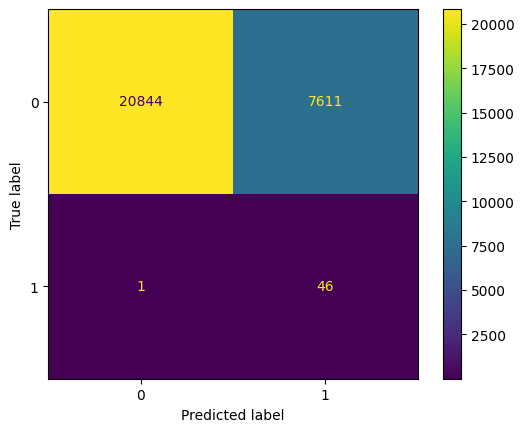

In [47]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))
)
disp.plot()

In [48]:
metrics.accuracy_score(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}']))

0.7329310223843941

In [49]:
print(metrics.classification_report(list(pred[f'{VAR_TARGET}']), list(pred[f'predicted_{VAR_TARGET}'])))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85     28455
           1       0.01      0.98      0.01        47

    accuracy                           0.73     28502
   macro avg       0.50      0.86      0.43     28502
weighted avg       1.00      0.73      0.84     28502



---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [50]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [51]:
explain.head()

,trial_id,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,8,1,0.532349,"[{'feature': 'V4', 'attribution': 1.3776598876...",-0.010373,0.129576,0.0,35337,1.092844,-0.013230,...,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0,0,a1b10547-d270-48c0-b902-7a0f735dadc7,TEST
1,8,0,0.549312,"[{'feature': 'V14', 'attribution': -0.85520383...",-0.010373,-0.197890,0.0,60481,1.238973,0.035226,...,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0,0,814c62c8-ade4-47d5-bf83-313b0aafdee5,TEST
2,8,1,0.542221,"[{'feature': 'V4', 'attribution': 1.9618240383...",-0.010373,0.169287,0.0,139587,1.870539,0.211079,...,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0,0,d08a1bfa-85c5-4f1b-9537-1c5a93e6afd0,TEST
3,8,0,0.577803,"[{'feature': 'V5', 'attribution': -1.357191102...",-0.010373,-0.313761,0.0,162908,-3.368339,-1.980442,...,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0,0,802f3307-8e5a-4475-b795-5d5d8d7d0120,TEST
4,8,0,0.577213,"[{'feature': 'V3', 'attribution': 1.7326584738...",-0.010373,-0.311341,0.0,165236,2.180149,0.218732,...,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.0,0,c8a5b93a-1598-4689-80be-4f9f5df0b8ce,TEST


Create a plot of feature attributions for a single prediction:

In [52]:
explanation = explain.iloc[0]['top_feature_attributions']

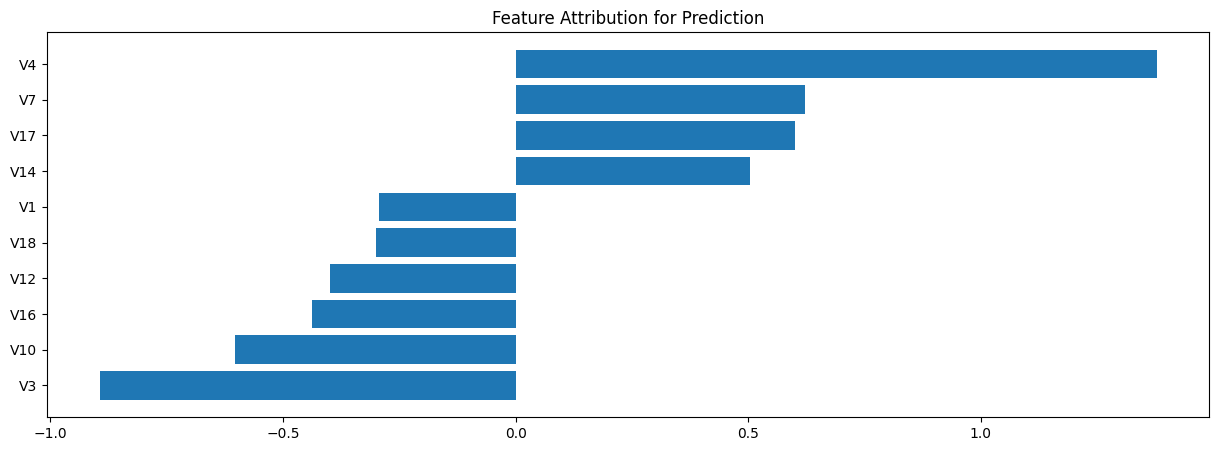

In [53]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [54]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [55]:
gexplain.head()

,trial_id,feature,attribution
0,8,V17,1.147853
1,8,V14,1.031917
2,8,V12,0.970989
3,8,V16,0.768079
4,8,V3,0.753790


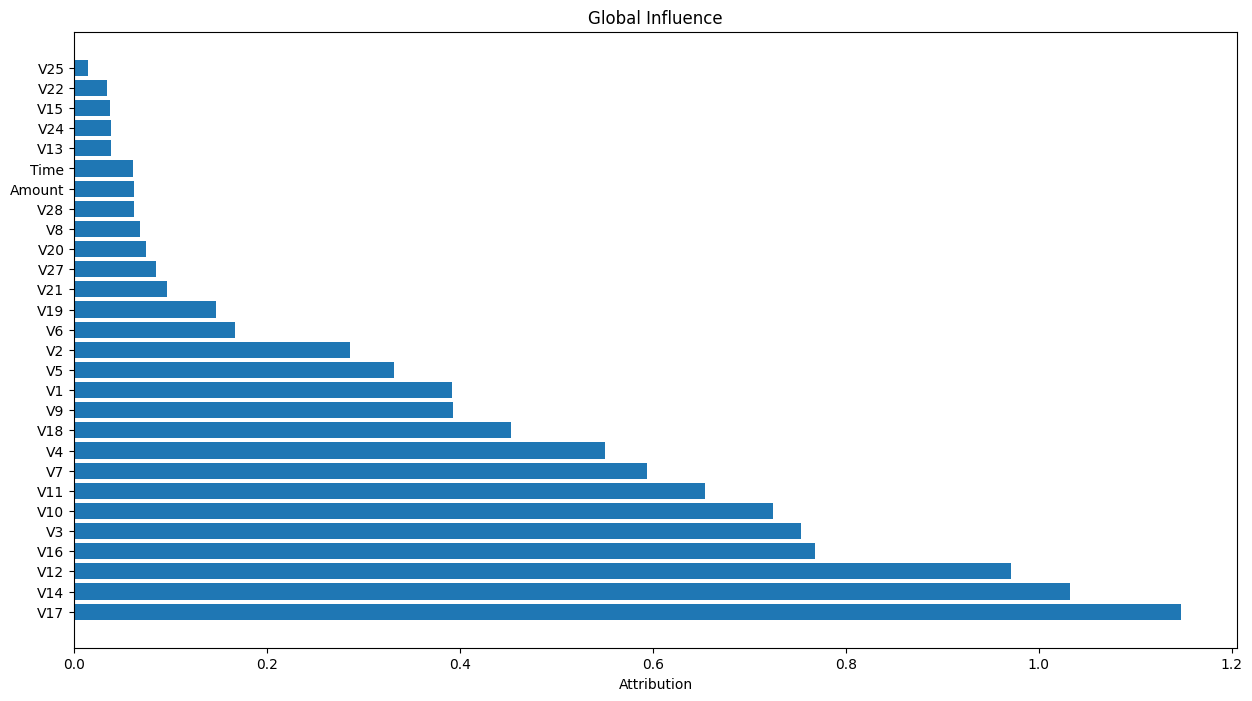

In [56]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

---
## Serving With Vertex AI

The training options for creating the model include registering the model the Vertex AI Automatically.  This makes deploying the model to a [Vertex AI Endpoint for online serving](https://cloud.google.com/vertex-ai/docs/general/deployment) very easy.

### Vertex AI Model Registry - Get Model

When these modes were trained in BigQuery ML they included options for registration in Vertex AI Model Registry.  This section shows how to retrieve the information from the model using the [Vertex AI Python Client](../Tips/aiplatform_notes.md).

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [87]:
vertex_model = aiplatform.Model(model_name = f'bqml_{SERIES}_{EXPERIMENT}')
vertex_model.resource_name

'projects/1026793852137/locations/us-central1/models/bqml_bqml_logistic-regression-hpt'

In [88]:
# note: this is blank since the model is managed by BQML and container is pre-specified
vertex_model.uri 

In [89]:
vertex_model.gca_resource

name: "projects/1026793852137/locations/us-central1/models/bqml_bqml_logistic-regression-hpt"
display_name: "bqml_bqml_logistic-regression-hpt"
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "bigquery"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
supported_output_storage_formats: "bigquery"
create_time {
  seconds: 1687869086
  nanos: 307532000
}
update_time {
  seconds: 1687869199
  nanos: 560869000
}
etag: "AMEw9yNg5FC6Qb0h4aoPOToUfWGnv6vHOjFWzPtYk6q5n1iMCIHPzDD9FCn5AM77ifY1"
explanation_spec {
  parameters {
    sampled_shapley_attribution {
      path_count: 5
    }
  }
  metadata {
    inputs {
      key: "Amount"
      value {
        input_tensor_name: "Amount:0"
        encoding: IDENTITY
        modality: "numeric"
     

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [90]:
if not aiplatform.Endpoint.list(filter = f"display_name={SERIES}"):
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}",
        labels = {'series' : f"{SERIES}"}
    )
    print(f"Endpoint Created: {endpoint.display_name}")
else:
    endpoint = aiplatform.Endpoint.list(filter = f"display_name={SERIES}")[0]
    print(f"Endpoint Found: {endpoint.display_name}")

Endpoint Found: bqml


In [91]:
endpoint.display_name

'bqml'

In [92]:
endpoint.traffic_split

{'5482237543858569216': 100}

In [93]:
deployed_models = endpoint.list_models()
for d in deployed_models: print(d.display_name)

bqml_bqml_kmeans


### Deploy Model To Vertex AI Endpoint

**NOTE: This can take 15+ minutes to complete.**

Reference:
- [aiplatform.Endpoint.deploy()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy)

In [94]:
endpoint.deploy(
    model = vertex_model,
    deployed_model_display_name = vertex_model.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1,
    explanation_parameters = aiplatform.explain.ExplanationParameters(), # supress the explanation specs from BQML during deployment
    explanation_metadata = aiplatform.explain.ExplanationMetadata()
)

Deploying Model projects/1026793852137/locations/us-central1/models/bqml_bqml_logistic-regression-hpt to Endpoint : projects/1026793852137/locations/us-central1/endpoints/5386265571916513280


INFO:google.cloud.aiplatform.models:Deploying Model projects/1026793852137/locations/us-central1/models/bqml_bqml_logistic-regression-hpt to Endpoint : projects/1026793852137/locations/us-central1/endpoints/5386265571916513280


Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/5386265571916513280/operations/115674326958604288


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/5386265571916513280/operations/115674326958604288


InvalidArgument: 400 Error occurred in Explanation preprocessing. <class 'TypeError'> 'NoneType' object is not iterable


---
# DEBUGGING

ERROR related to explanationspec from BQML registering model in Vertex AI Model Registry.  View the spec with `vertex_model.gca_resource`

---

In [ ]:
endpoint.list_models()

### Remove Deployed Models without Traffic

In [ ]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

In [ ]:
endpoint.traffic_split

In [ ]:
#endpoint.list_models()

---
## Predictions With Vertex AI Endpoint

### Retrieve Records For Prediction

In [ ]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

Shape as instances: dictionaries of key:value pairs for only features used in model

In [ ]:
newobs = pred.to_dict(orient = 'records')

In [ ]:
newobs[0]

### Get Predictions: Python Client

In [ ]:
prediction = endpoint.predict(instances = newobs[0:1])
prediction

In [ ]:
prediction.predictions[0]

In [ ]:
np.argmax(prediction.predictions[0])

### Get Predictions: REST
Reference:
- [POST https://{REGION}-aiplatform.googleapis.com/v1/{endpoint}:predict](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.prediction_service.PredictionServiceClient#google_cloud_aiplatform_v1_services_prediction_service_PredictionServiceClient_predict)

Prepare request:

In [ ]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [ ]:
prediction = !curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

prediction

Format raw prediction response using JSON:

### Get Predictions: gcloud (CLI)
Reference:
- [gcloud ai endpoints predict](https://cloud.google.com/sdk/gcloud/reference/ai/endpoints/predict)

Prepare request:

In [ ]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": newobs[0:1]}))

Prediction:

In [ ]:
prediction = !gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json
prediction

---
## Export Model

The model created in BigQuery ML can be exported to their native model types save files.  This process saves the model artifacts in GCS where they can be use anywhere they are needed.  For instance, they could be imported into the Vertex AI Model Registry for use in online and batch serving - however, this process is automated with the training options use above.

### Export the BigQuery Model


The models trained in BQML can be exported from BigQuery to GCS:

Reference:
- [Exporting Models](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [ ]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [ ]:
(export.ended - export.started).total_seconds()

In [ ]:
listing = !gsutil ls gs://{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model
listing

In [ ]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{BUCKET}/{SERIES}/{EXPERIMENT}/models/{TIMESTAMP}/model?project={PROJECT_ID}")

### Detect The Model Types Framework

In [ ]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(list(set(filetypes))) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

In [ ]:
list(set(filetypes))

---
## Remove Resources

The following cells have commented out statements that can be used to remove resources created by this notebook.  Other notebooks in the repository will reusue the same endpoint so it may be desired to not remove the endpoint if you plan to run additional notebooks.  Otherwise, please removed the endpoint to prevent ongoing cost from hosting the models on Vertex AI Endpoints.

Similarly, if you want to remove the model from BQML to prevent the minimal storage cost it will automatically be removed from Vertex AI Model Registry as well.

In [100]:
# delete endpoint, use `force` incase models are deployed or undeploy them first
#endpoint.delete(force = True)

In [99]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
#bq.delete_model(model)